# Read data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Resume.csv")

In [3]:
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [4]:
df.drop(columns="Resume_html" , inplace=True , axis=1)

In [5]:
df.isnull().any()

ID            False
Resume_str    False
Category      False
dtype: bool

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df['Category'].value_counts()

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

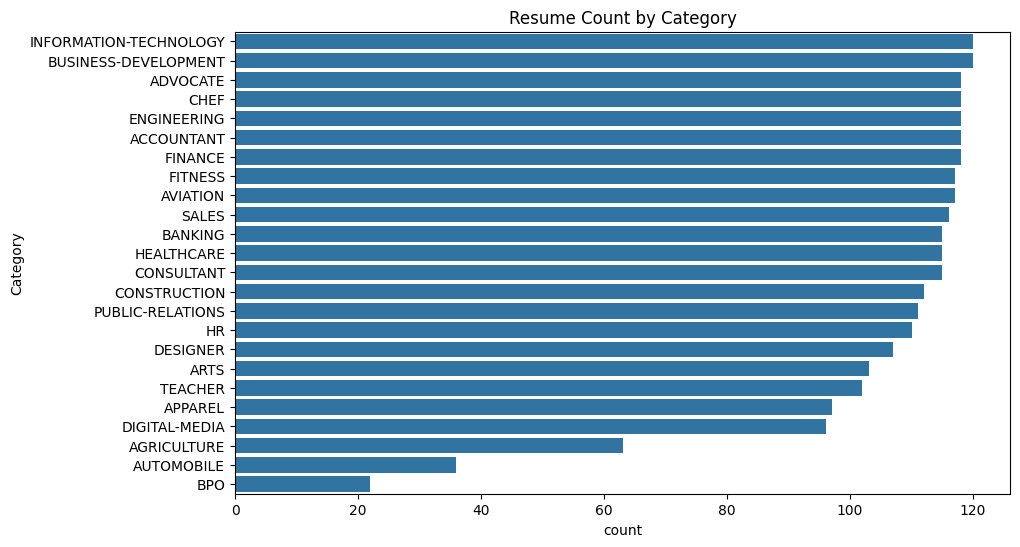

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, y='Category', order=df['Category'].value_counts().index)
plt.title("Resume Count by Category")
plt.show()

# Preproccing

In [10]:
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")  

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Remo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Remo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def clean_text(text):
    if pd.isnull(text):
        return "", [], [], []

    # Lowercase
    text = text.lower()
    # Remove URLs, emails, phone numbers
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\b\d{10,13}\b', '', text)
    text = re.sub(r'(\+?\d{1,2}[\s-]?)?(\(?\d{3}\)?[\s-]?)?\d{3}[\s-]?\d{4}', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Create SpaCy doc from joined tokens
    doc = nlp(' '.join(tokens))
    # Lemmatization
    lemmatized = [token.lemma_ for token in doc]
    # Named Entity Recognition
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    # Extract by entity type
    education = [ent[0] for ent in entities if ent[1] in ["ORG"]] 
    experience = [ent[0] for ent in entities if ent[1] == "DATE"]
    skills = [token.text for token in doc if token.pos_ == "NOUN" and token.text not in stop_words]

    cleaned_text = ' '.join(lemmatized)

    return cleaned_text, skills, education, experience

In [12]:
df[['cleaned_resume', 'skills', 'education', 'experience']] = df['Resume_str'].apply(
    lambda x: pd.Series(clean_text(x))
)

In [13]:
df.head()

,ID,Resume_str,Category,cleaned_resume,skills,education,experience
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,hr administratormarkete associate hr administr...,"[hr, hr, administrator, summary, customer, ser...",[business administration jefferson college cit...,"[years, months, daily]"
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,hr specialist we hr operation summary versatil...,"[hr, specialist, operations, media, background...",[lotus],"[monthly, quarterly, annual, daily, monthly, q..."
2,33176873,HR DIRECTOR Summary Over 2...,HR,hr director summary year experience recruiting...,"[director, summary, years, experience, recruit...","[hris development benefit administration, kans...","[years, plus years, maintenance years]"
3,27018550,HR SPECIALIST Summary Dedica...,HR,hr specialist summary dedicate drive dynamic y...,"[summary, years, customer, service, expertise,...","[microsoft, microsoft, microsoft, microsoft, m...",[years]
4,17812897,HR MANAGER Skill Highlights ...,HR,hr manager skill highlight hr skill hr departm...,"[hr, manager, skill, highlights, hr, hr, depar...","[quality associates department, vltd k success...","[annual, first month, friday, first year, annual]"


In [16]:
df['skills'] = df['skills'].apply(lambda x: list(set(x)))
df['skills'].duplicated().sum()

np.int64(3)

In [28]:
df['experience'] = df['experience'].apply(lambda x: list(set(x)))
df['experience'].duplicated().sum()

np.int64(609)

In [18]:
df['word_count'] = df['cleaned_resume'].apply(lambda x: len(x.split()))
df['char_count'] = df['cleaned_resume'].apply(len)

# Visualization

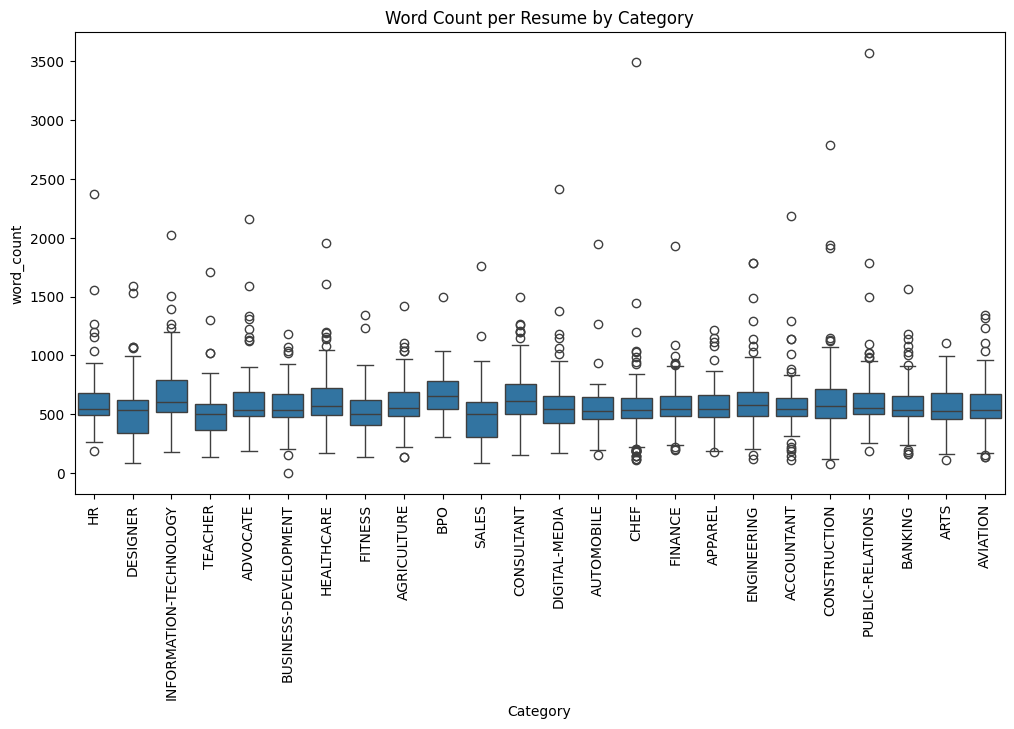

In [19]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='Category', y='word_count')
plt.xticks(rotation=90)
plt.title("Word Count per Resume by Category")
plt.show()

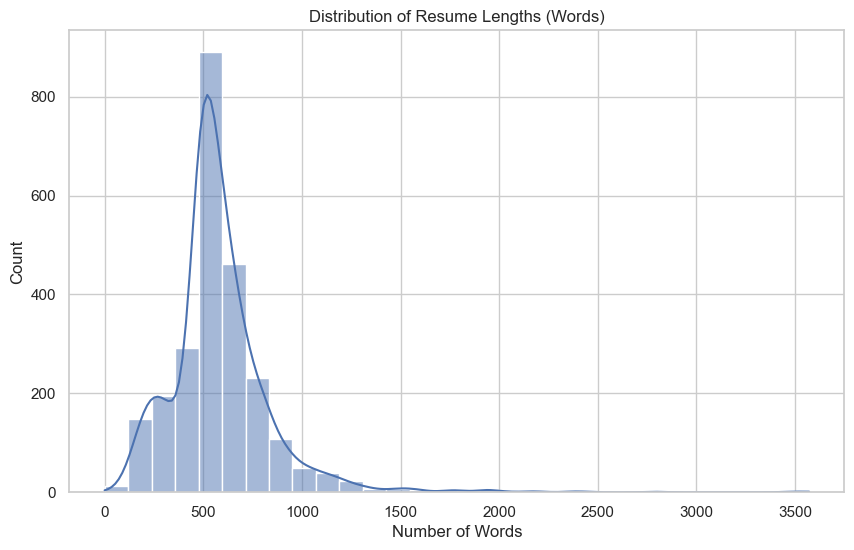

In [26]:
df['resume_length'] = df['cleaned_resume'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.histplot(df['resume_length'], bins=30, kde=True)
plt.title('Distribution of Resume Lengths (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()


In [20]:
from collections import Counter

category_top_words = {}
def get_top_words(texts, n=20):
    all_words = ' '.join(texts).split()
    return Counter(all_words).most_common(n)

for category in df['Category'].unique():
    resumes = df[df['Category'] == category]['cleaned_resume']
    top_words = get_top_words(resumes, n=20)
    category_top_words[category] = top_words

for category, words in category_top_words.items():
    print(f"\nTop words for {category}:")
    print(words)



Top words for HR:
[('employee', 1298), ('hr', 1029), ('management', 937), ('company', 750), ('state', 670), ('resource', 608), ('human', 592), ('city', 567), ('process', 540), ('name', 456), ('training', 453), ('program', 441), ('benefit', 435), ('new', 434), ('manager', 417), ('skill', 404), ('policy', 391), ('hire', 381), ('business', 381), ('maintain', 354)]

Top words for DESIGNER:
[('design', 1225), ('city', 729), ('state', 724), ('company', 659), ('designer', 548), ('name', 547), ('project', 438), ('work', 424), ('create', 326), ('product', 311), ('client', 307), ('graphic', 288), ('skill', 286), ('customer', 283), ('experience', 268), ('use', 263), ('develop', 251), ('art', 240), ('development', 238), ('team', 229)]

Top words for INFORMATION-TECHNOLOGY:
[('system', 1282), ('management', 891), ('information', 854), ('network', 814), ('technology', 809), ('support', 775), ('project', 699), ('company', 655), ('state', 641), ('city', 614), ('business', 546), ('server', 537), ('nam

## See the top 10 words for each category

C:\Users\Remo\AppData\Local\Temp\ipykernel_12816\2854984649.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=axes[idx], palette='viridis')
C:\Users\Remo\AppData\Local\Temp\ipykernel_12816\2854984649.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=axes[idx], palette='viridis')
C:\Users\Remo\AppData\Local\Temp\ipykernel_12816\2854984649.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=axes[idx], palette='viridis')
C:\Users\Remo\Ap

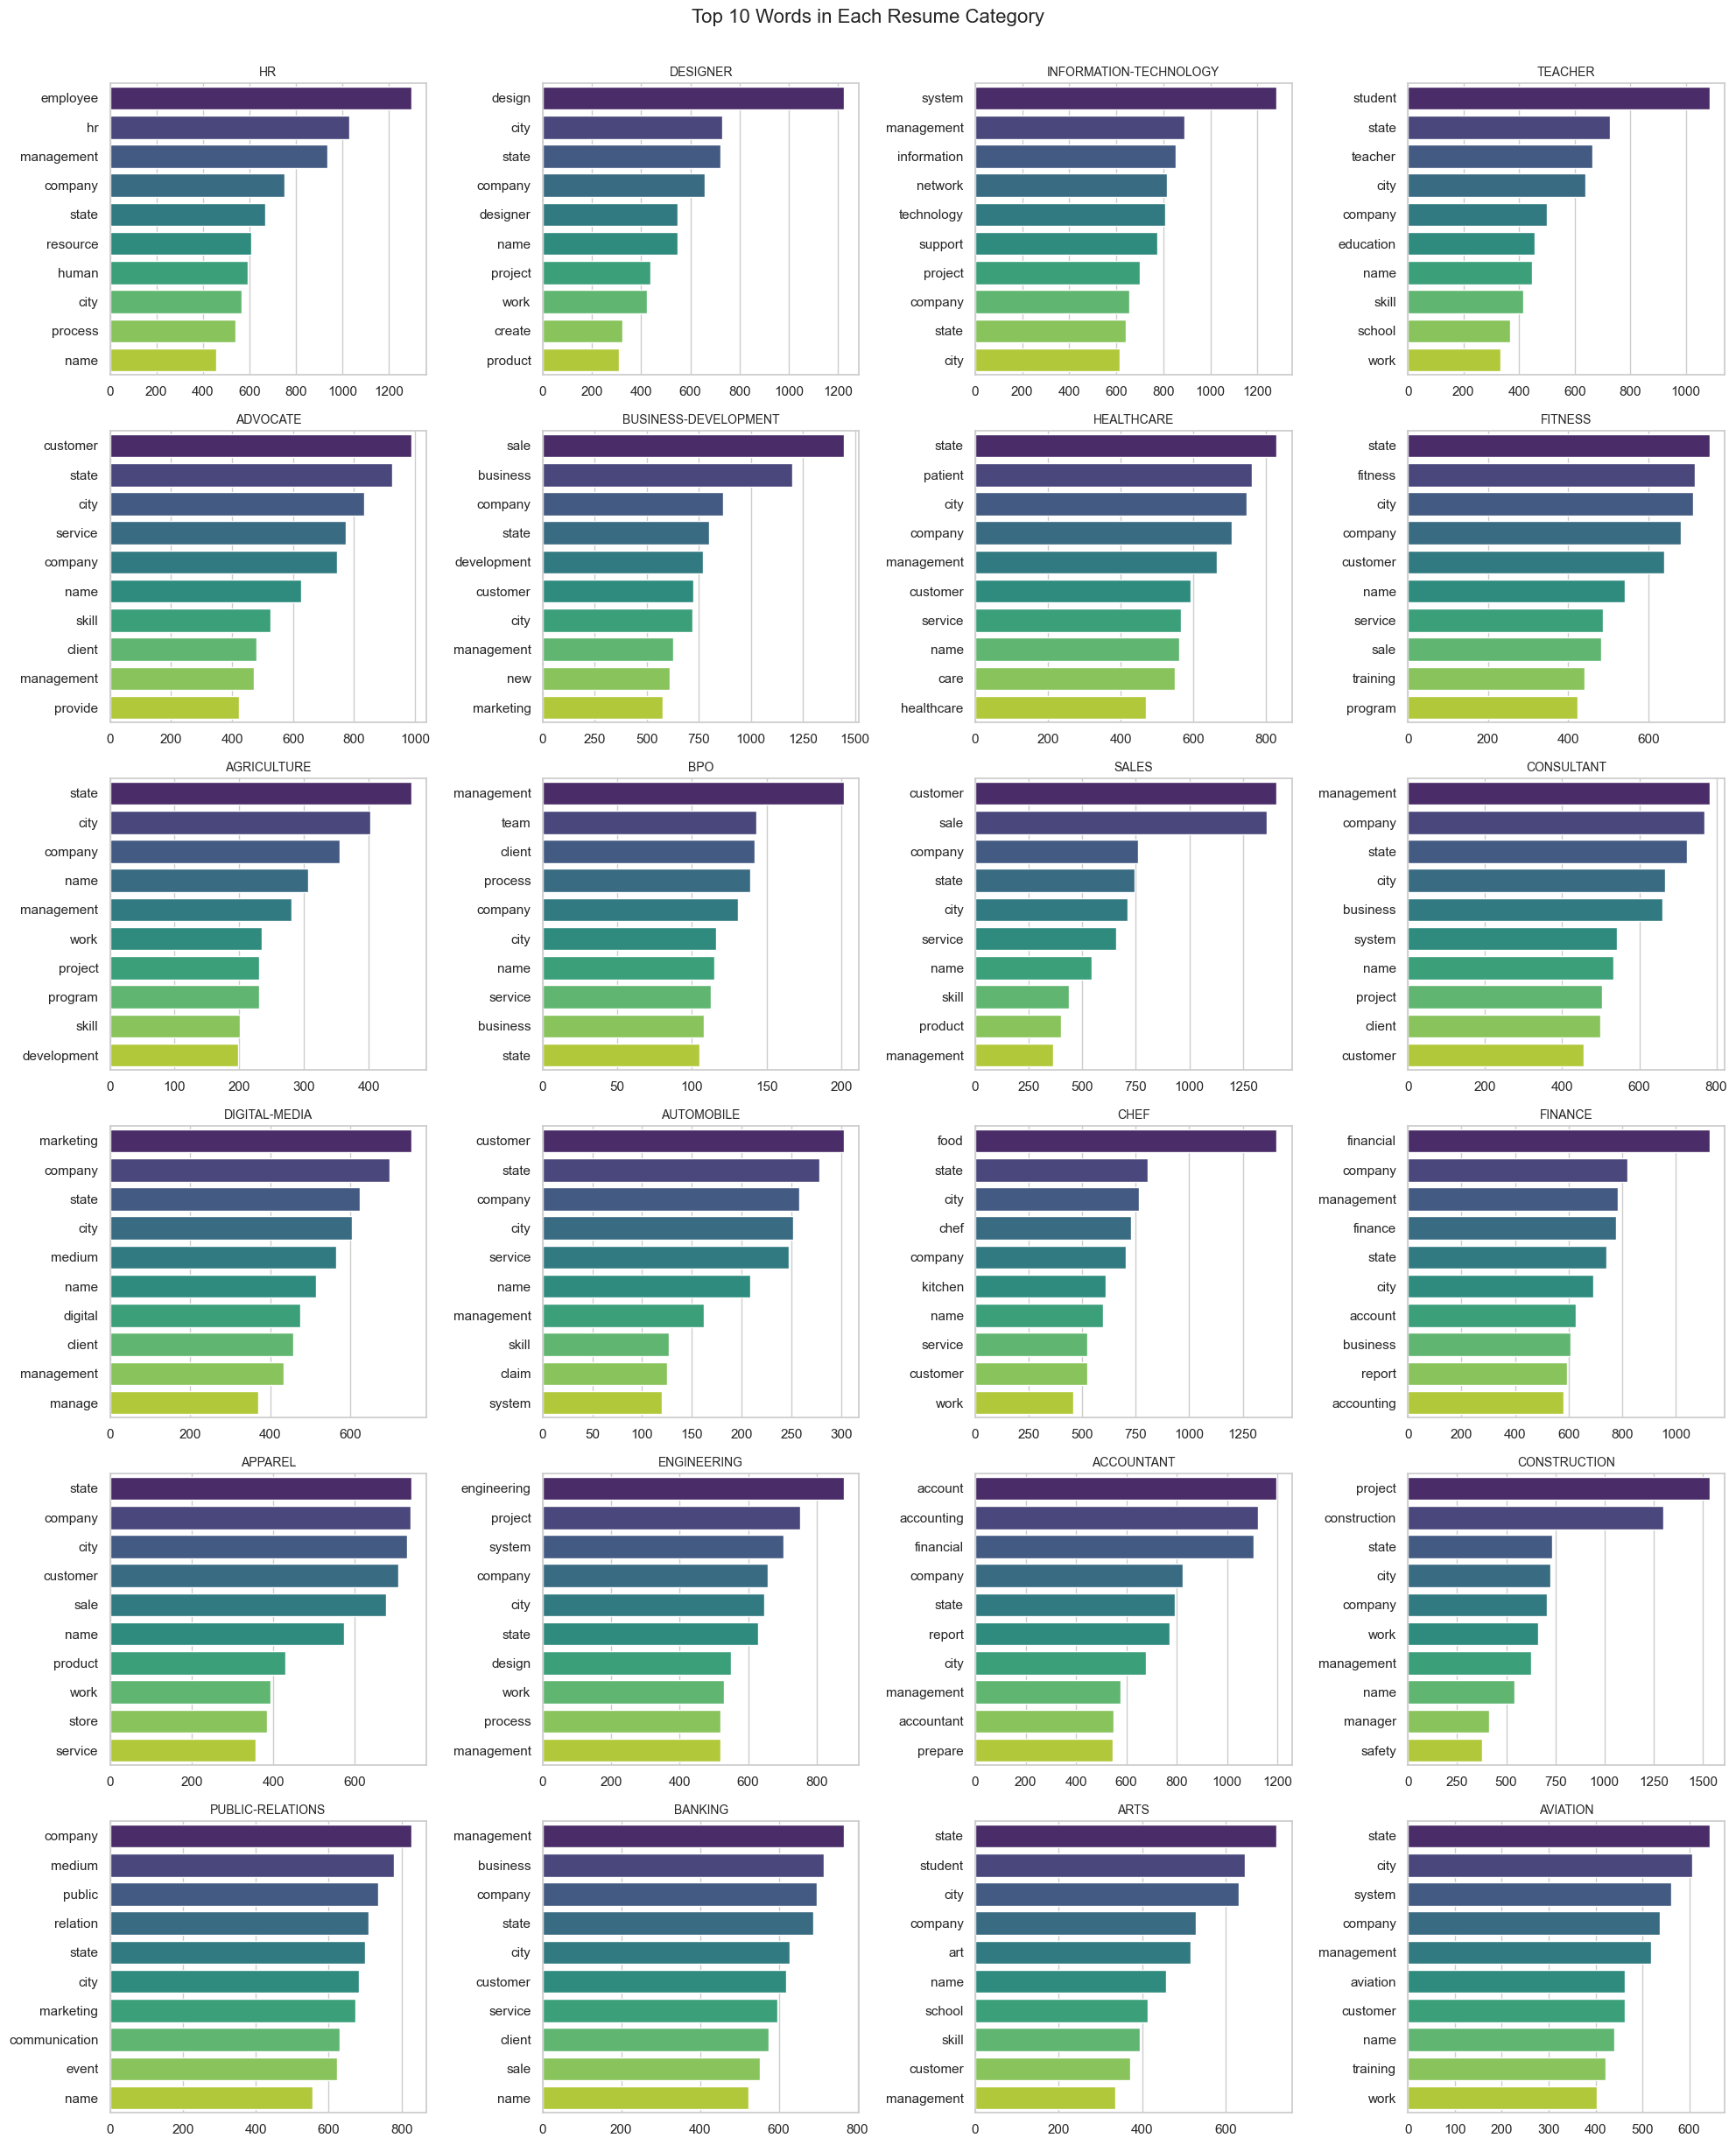

In [21]:
sns.set(style="whitegrid")
num_categories = len(category_top_words)
cols = 4  
rows = (num_categories // cols) + (num_categories % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
axes = axes.flatten()

for idx, (category, top_words) in enumerate(category_top_words.items()):
    words, counts = zip(*top_words[:10])
    sns.barplot(x=list(counts), y=list(words), ax=axes[idx], palette='viridis')
    axes[idx].set_title(category, fontsize=10)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle("Top 10 Words in Each Resume Category", fontsize=16, y=1.02)
plt.show()


## See top 20 most Comman Skills

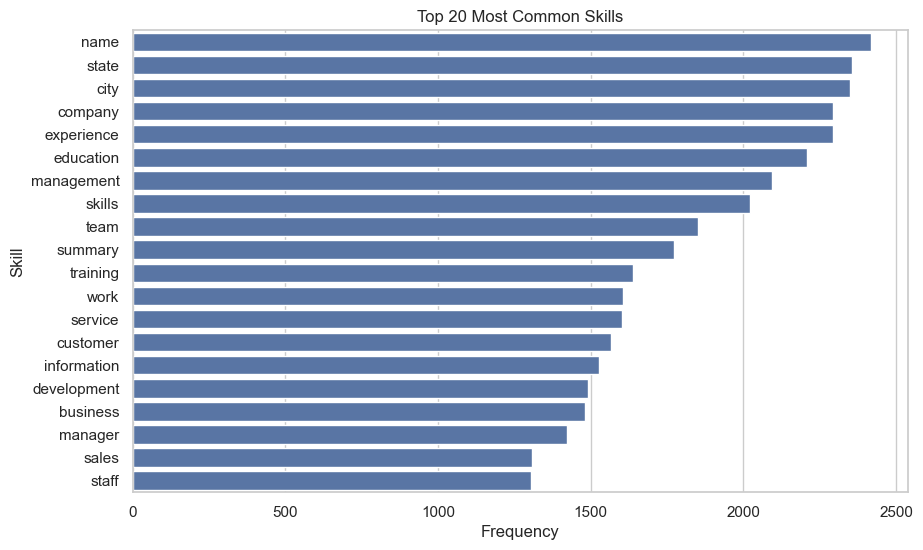

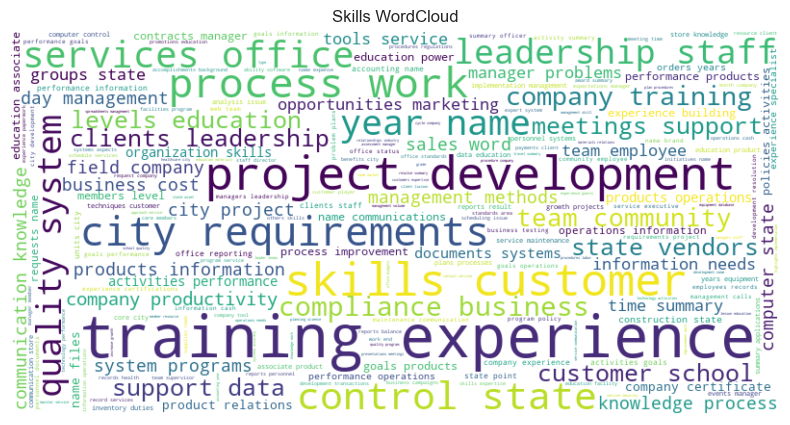

In [24]:
from collections import Counter
from wordcloud import WordCloud

# Flatten skills list
all_skills = [skill for skills_list in df['skills'] for skill in skills_list]
top_skills = Counter(all_skills).most_common(20)

# Bar Chart
skills_df = pd.DataFrame(top_skills, columns=['Skill', 'Frequency'])
plt.figure(figsize=(10,6))
sns.barplot(data=skills_df, x='Frequency', y='Skill')
plt.title('Top 20 Most Common Skills')
plt.show()

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_skills))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Skills WordCloud')
plt.show()


## Show most common education terms

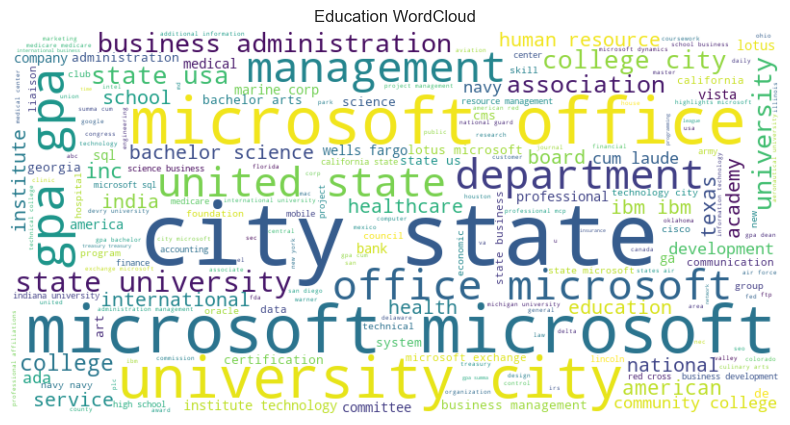

In [27]:
education_terms = [edu for sublist in df['education'] for edu in sublist]
edu_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(education_terms))
plt.figure(figsize=(10,5))
plt.imshow(edu_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Education WordCloud')
plt.show()


## Show most common Experience terms

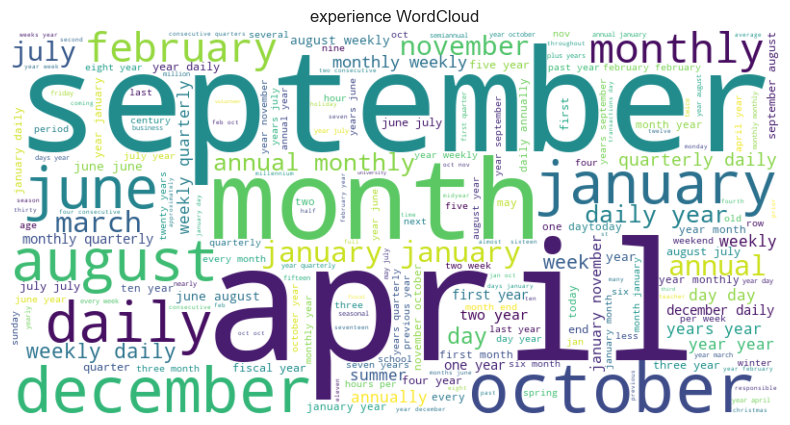

In [34]:
experience_terms = [edu for sublist in df['experience'] for edu in sublist]
exp_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(experience_terms))
plt.figure(figsize=(10,5))
plt.imshow(exp_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('experience WordCloud')
plt.show()


# Vectorization

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=20)  # Limit to 20 important terms

tfidf_matrix = vectorizer.fit_transform(df['cleaned_resume'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Show the top 20 TF-IDF features for each resume
df_top_keywords = tfidf_df.apply(lambda row: row.nlargest(5).index.tolist(), axis=1)

df['top_keywords'] = df_top_keywords

df[['cleaned_resume', 'top_keywords']].head()


,cleaned_resume,top_keywords
0,hr administratormarkete associate hr administr...,"[customer, service, company, state, city]"
1,hr specialist we hr operation summary versatil...,"[company, state, sale, new, city]"
2,hr director summary year experience recruiting...,"[management, state, develop, new, city]"
3,hr specialist summary dedicate drive dynamic y...,"[client, customer, management, maintain, service]"
4,hr manager skill highlight hr skill hr departm...,"[management, business, team, manage, develop]"


## Use BERT for Semantic Matching

In [39]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def vectorize_with_bert(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

df['resume_vector_bert'] = df['cleaned_resume'].apply(lambda x: vectorize_with_bert(x, tokenizer, bert_model))

df['resume_vector_bert'].head()


c:\Users\Remo\anaconda3\envs\NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Remo\anaconda3\envs\NLP\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Remo\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, 

0    [-0.048330918, 0.27854308, 0.559267, -0.382291...
1    [0.010374121, 0.2632338, 0.69570607, -0.392331...
2    [-0.2516668, 0.26389462, 0.55114806, -0.343573...
3    [-0.32186413, 0.38931775, 0.6157576, -0.297388...
4    [-0.14037749, 0.2992703, 0.699144, -0.40076578...
Name: resume_vector_bert, dtype: object

In [40]:
df.head()

,ID,Resume_str,Category,cleaned_resume,skills,education,experience,word_count,char_count,skills_str,resume_length,top_keywords,resume_vector_bert
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,hr administratormarkete associate hr administr...,"[clients, leadership, facilitate, staff, clien...",[business administration jefferson college cit...,"[daily, years, months]",494,4080,clients leadership facilitate staff client hr ...,494,"[customer, service, company, state, city]","[-0.048330918, 0.27854308, 0.559267, -0.382291..."
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,hr specialist we hr operation summary versatil...,"[salary, head, draft, university, managers, cl...",[lotus],"[daily, annual, monthly, quarterly]",525,4155,salary head draft university managers clients ...,525,"[company, state, sale, new, city]","[0.010374121, 0.2632338, 0.69570607, -0.392331..."
2,33176873,HR DIRECTOR Summary Over 2...,HR,hr director summary year experience recruiting...,"[rate, resource, managers, leadership, staff, ...","[hris development benefit administration, kans...","[years, plus years, maintenance years]",701,5674,rate resource managers leadership staff ideas ...,701,"[management, state, develop, new, city]","[-0.2516668, 0.26389462, 0.55114806, -0.343573..."
3,27018550,HR SPECIALIST Summary Dedica...,HR,hr specialist summary dedicate drive dynamic y...,"[clients, staff, disability, success, client, ...","[microsoft, microsoft, microsoft, microsoft, m...",[years],261,2055,clients staff disability success client repres...,261,"[client, customer, management, maintain, service]","[-0.32186413, 0.38931775, 0.6157576, -0.297388..."
4,17812897,HR MANAGER Skill Highlights ...,HR,hr manager skill highlight hr skill hr departm...,"[salary, affiliations, resource, managers, lea...","[quality associates department, vltd k success...","[first year, annual, friday, first month]",871,7063,salary affiliations resource managers leadersh...,871,"[management, business, team, manage, develop]","[-0.14037749, 0.2992703, 0.699144, -0.40076578..."


In [41]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarities = cosine_similarity(list(df['resume_vector_bert']))

df['custom_similarity_score'] = cosine_similarities.mean(axis=1)

df[['cleaned_resume', 'custom_similarity_score']].head()


,cleaned_resume,custom_similarity_score
0,hr administratormarkete associate hr administr...,0.941812
1,hr specialist we hr operation summary versatil...,0.941879
2,hr director summary year experience recruiting...,0.936580
3,hr specialist summary dedicate drive dynamic y...,0.920913
4,hr manager skill highlight hr skill hr departm...,0.934602


In [42]:
df.columns

Index(['ID', 'Resume_str', 'Category', 'cleaned_resume', 'skills', 'education',
       'experience', 'word_count', 'char_count', 'skills_str', 'resume_length',
       'top_keywords', 'resume_vector_bert', 'custom_similarity_score'],
      dtype='object')

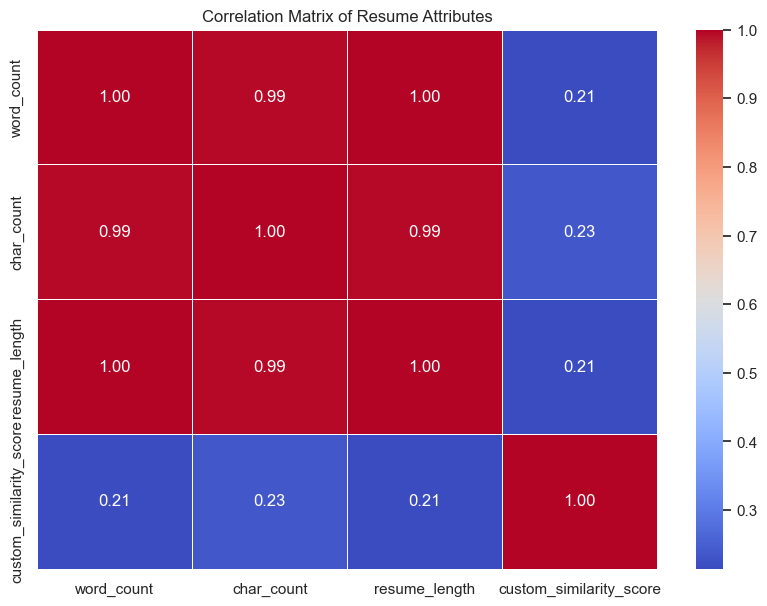

In [48]:
numeric_columns = ['word_count', 'char_count', 'resume_length', 'custom_similarity_score']
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Resume Attributes")
plt.show()
